In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Load optimized dataset
df = pd.read_csv("optimized_dataset.csv")

# Separate features and target variables
X = df.iloc[:, :-6]  # Exclude jet position columns
y = df[["jet1_x", "jet1_y", "jet1_z", "jet2_x", "jet2_y", "jet2_z"]]

# Split into 80% training, 20% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Save datasets for model training
X_train.to_csv("X_train.csv", index=False)
X_test.to_csv("X_test.csv", index=False)
y_train.to_csv("y_train.csv", index=False)
y_test.to_csv("y_test.csv", index=False)

print("Training & testing datasets created successfully")


Training & testing datasets created successfully!


#### starting with lstm and cnn 

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Flatten
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

#  Load & Preprocess Data
df = pd.read_csv("optimized_dataset.csv")

X = df.iloc[:, :-6].values  # Features (Exclude jet position columns)
y = df[["jet1_x", "jet1_y", "jet1_z", "jet2_x", "jet2_y", "jet2_z"]].values  # Target Variables

#  Normalize Features
scaler = StandardScaler()
X = scaler.fit_transform(X)

#  Reshape Data for CNN-LSTM Input
X = X.reshape((X.shape[0], X.shape[1], 1))  # CNN expects 3D input

#  Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define CNN-LSTM Model Architecture
model = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)),
    MaxPooling1D(pool_size=2),
    LSTM(units=50, return_sequences=True),
    LSTM(units=50),
    Dense(units=64, activation='relu'),
    Dense(units=6)  # Output layer (predicting 6 jet position values)
])

#  Compile Model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

#  Train Model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

#  Evaluate Model
loss, mae = model.evaluate(X_test, y_test)
print(f" Model Training Complete!")
print(f" Loss (MSE): {loss:.2f}")
print(f" MAE: {mae:.2f}")

#  Save Model
model.save("cnn_lstm_model.h5")


c:\Users\priks\anaconda3\envs\health\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - loss: 277896800.0000 - mae: 8308.7500 - val_loss: 271162656.0000 - val_mae: 8234.9482
Epoch 2/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - loss: 274526848.0000 - mae: 8254.1221 - val_loss: 271162208.0000 - val_mae: 8234.9609
Epoch 3/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - loss: 275622976.0000 - mae: 8275.8896 - val_loss: 271161120.0000 - val_mae: 8234.9355
Epoch 4/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - loss: 277537312.0000 - mae: 8307.4512 - val_loss: 271159904.0000 - val_mae: 8234.9385
Epoch 5/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - loss: 279884704.0000 - mae: 8357.9170 - val_loss: 271158944.0000 - val_mae: 8234.9209
Epoch 6/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - loss: 276970112.0000 - mae: 8302.4424 - val_loss: 271156832.0000 - val_mae: 8234.9082
Epoch 7/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - loss: 277262304.0000 - mae: 8305.3789 - val_loss: 271155296.0000 - val_mae: 8234.8994
Epoch 8/50
37

✅ Model Training Complete!
📌 Loss (MSE): 271126944.00
📌 MAE: 8234.76


####Multistepiterativeapproach

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler

#  Load Dataset
df = pd.read_csv("optimized_dataset.csv")

#  Feature Selection: Extract Time-Series Data
target_columns = ["jet1_x", "jet1_y", "jet1_z", "jet2_x", "jet2_y", "jet2_z"]
X = df[target_columns].values  # Using jet positions for multi-step forecasting

#  Normalize Features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

#  Define Multi-Step Forecasting Parameters
lookback = 10  # Use past 10 timesteps to predict next position
forecast_steps = 5  # Predict 5 future timesteps

#  Create Sequential Data for LSTM
def create_sequences(data, lookback, forecast_steps):
    X_seq, y_seq = [], []
    for i in range(len(data) - lookback - forecast_steps):
        X_seq.append(data[i:i + lookback])
        y_seq.append(data[i + lookback:i + lookback + forecast_steps])
    return np.array(X_seq), np.array(y_seq)

X_seq, y_seq = create_sequences(X_scaled, lookback, forecast_steps)

#  Reshape y_seq for Model Compatibility
y_seq = y_seq.reshape(y_seq.shape[0], forecast_steps * len(target_columns))

#  Split into Training & Testing Sets
split = int(0.8 * len(X_seq))
X_train, X_test = X_seq[:split], X_seq[split:]
y_train, y_test = y_seq[:split], y_seq[split:]

#  Define Multi-Step LSTM Model
model = Sequential([
    LSTM(units=100, activation='relu', return_sequences=True, input_shape=(lookback, len(target_columns))),
    LSTM(units=50, activation='relu', return_sequences=False),
    Dense(units=forecast_steps * len(target_columns), activation='linear')  # Fixed output shape
])

#  Compile Model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), loss='mse')

#  Train Model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

#  Evaluate Model
loss = model.evaluate(X_test, y_test)
print(f" Multi-Step LSTM Model Training Complete!")
print(f" Loss (MSE): {loss:.2f}")

#  Save Model
model.save("multi_step_lstm_model.h5")

#  Make Future Predictions
future_preds = model.predict(X_test[:1])  # Predict next few timesteps
future_preds = scaler.inverse_transform(future_preds.reshape(forecast_steps, len(target_columns)))  # Convert back to original scale
print(" Next Predicted Jet Positions:", future_preds)


Epoch 1/50


c:\Users\priks\anaconda3\envs\health\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


375/375 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.1507 - val_loss: 0.0827
Epoch 2/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0840 - val_loss: 0.0824
Epoch 3/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.0837 - val_loss: 0.0826
Epoch 4/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.0839 - val_loss: 0.0823
Epoch 5/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - loss: 0.0836 - val_loss: 0.0823
Epoch 6/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - loss: 0.0836 - val_loss: 0.0823
Epoch 7/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - loss: 0.0836 - val_loss: 0.0823
Epoch 8/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 11s 27ms/step - loss: 0.0835 - val_loss: 0.0825
Epoch 9/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - loss: 0.0836 - val_loss: 0.0822
Epoch 10/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - loss: 0.0837 - val_loss: 0.0825
Epoch 11/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - loss: 0.0833 - val_loss: 0.0823
Epoch 12/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/ste

✅ Multi-Step LSTM Model Training Complete!
📌 Loss (MSE): 0.08
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step
🔹 Next Predicted Jet Positions: [[-3.5762251e+03  2.8611317e+00 -4.2157877e-02 -2.3358821e+03
   2.5898302e+00 -3.7434667e-02]
 [-2.6394683e+03  2.9800625e+00 -6.0724255e-02 -9.3627319e+02
   2.6502662e+00 -4.5806874e-02]
 [-1.0523468e+03  2.8587823e+00 -3.8127102e-02 -3.6881360e+03
   2.5991812e+00  1.6017031e-02]
 [-1.2252361e+03  2.7681823e+00 -4.8943006e-02  5.8078094e+02
   2.8578272e+00 -4.5501813e-03]
 [-3.0042773e+03  2.7674122e+00 -2.2332635e-02 -8.1278107e+02
   2.8821940e+00  5.7490438e-04]]


In [37]:
# ✅ Reshape predictions correctly before inverse scaling
predicted_positions = predicted_positions.reshape(predicted_positions.shape[0], forecast_steps, len(target_columns))  # Reshape back to (samples, timesteps, features)

# ✅ Rescale each timestep independently
predicted_positions = np.array([scaler.inverse_transform(pred) for pred in predicted_positions])  # Apply inverse transform per timestep


####  Multi-Step LSTM iterative approach optimised

c:\Users\priks\anaconda3\envs\health\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - loss: 0.1595 - val_loss: 0.0828
Epoch 2/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0840 - val_loss: 0.0825
Epoch 3/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0836 - val_loss: 0.0826
Epoch 4/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 0.0836 - val_loss: 0.0824
Epoch 5/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 0.0836 - val_loss: 0.0824
Epoch 6/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0836 - val_loss: 0.0822
Epoch 7/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 0.0837 - val_loss: 0.0828
Epoch 8/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0835 - val_loss: 0.0823
Epoch 9/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.0835 - val_loss: 0.0825
Epoch 10/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.0837 - val_loss: 0.0826
Epoch 11/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.0834 - val_loss: 0.0824
Epoch 12/50
375/375 ━━━━━━━━━━━━━━━━━━━━

✅ Multi-Step LSTM Model Training Complete!
📌 Loss (MSE): 0.08


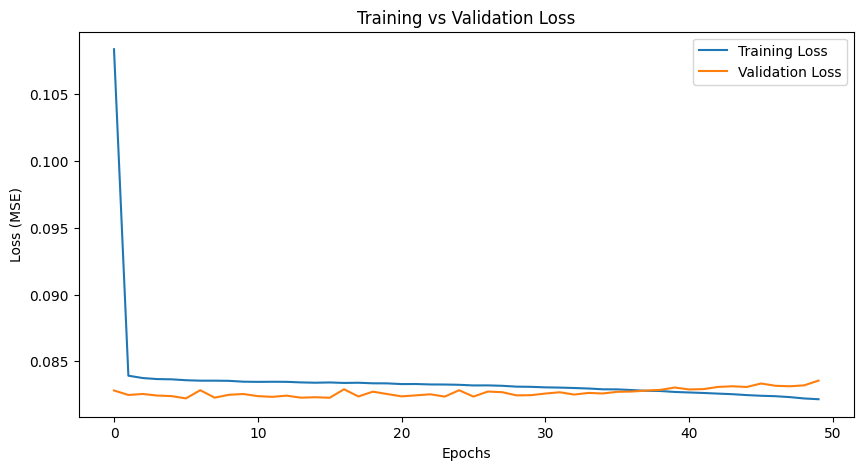

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step


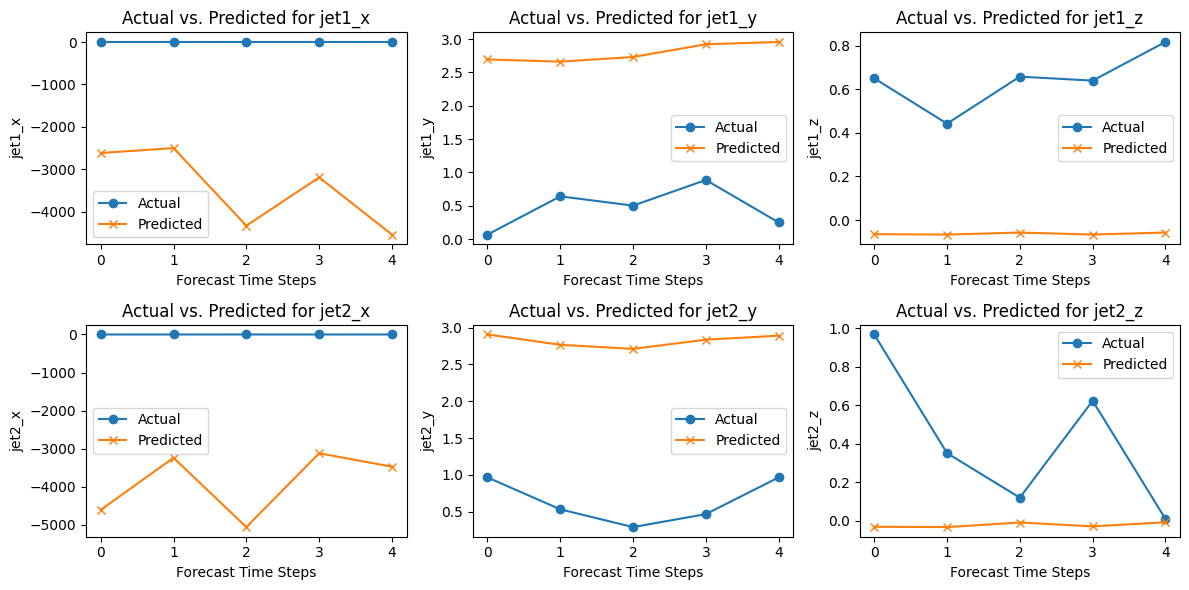

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf   
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler

# Load Dataset
df = pd.read_csv("optimized_dataset.csv")

#  Feature Selection: Extract Time-Series Data
target_columns = ["jet1_x", "jet1_y", "jet1_z", "jet2_x", "jet2_y", "jet2_z"]
X = df[target_columns].values  # Using jet positions for multi-step forecasting

# Normalize Features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

#  Define Multi-Step Forecasting Parameters
lookback = 10  # Use past 10 timesteps to predict next position
forecast_steps = 5  # Predict 5 future timesteps

#  Create Sequential Data for LSTM
def create_sequences(data, lookback, forecast_steps):
    X_seq, y_seq = [], []
    for i in range(len(data) - lookback - forecast_steps):
        X_seq.append(data[i:i + lookback])
        y_seq.append(data[i + lookback:i + lookback + forecast_steps])
    return np.array(X_seq), np.array(y_seq)

X_seq, y_seq = create_sequences(X_scaled, lookback, forecast_steps)

# Reshape y_seq for Model Compatibility
y_seq = y_seq.reshape(y_seq.shape[0], forecast_steps * len(target_columns))

#  Split into Training & Testing Sets
split = int(0.8 * len(X_seq))
X_train, X_test = X_seq[:split], X_seq[split:]
y_train, y_test = y_seq[:split], y_seq[split:]

#  Define Multi-Step LSTM Model
model = Sequential([
    LSTM(units=100, activation='relu', return_sequences=True, input_shape=(lookback, len(target_columns))),
    LSTM(units=50, activation='relu', return_sequences=False),
    Dense(units=forecast_steps * len(target_columns), activation='linear')  # Fixed output shape
])

# Compile Model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), loss='mse')

#  Train Model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

#  Evaluate Model
loss = model.evaluate(X_test, y_test)
print(f" Multi-Step LSTM Model Training Complete!")
print(f" Loss (MSE): {loss:.2f}")

#  Save Model
model.save("multi_step_lstm_model.h5")

#  Plot Training & Validation Loss
plt.figure(figsize=(10,5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.title('Training vs Validation Loss')
plt.legend()
plt.show()

#  Make Future Predictions
predicted_positions = model.predict(X_test[:5])  # Generate predictions

#  Correctly Reshape & Apply Inverse Scaling
predicted_positions = predicted_positions.reshape(predicted_positions.shape[0], forecast_steps, len(target_columns))  
predicted_positions = np.array([scaler.inverse_transform(pred) for pred in predicted_positions])  # Inverse scaling per step

#  Compare Actual vs. Predicted Jet Positions
actual_positions = y_test[:5].reshape(5, forecast_steps, len(target_columns))

plt.figure(figsize=(12,6))
for i in range(len(target_columns)):
    plt.subplot(2,3,i+1)
    plt.plot(range(forecast_steps), actual_positions[0, :, i], marker='o', label='Actual')
    plt.plot(range(forecast_steps), predicted_positions[0, :, i], marker='x', label='Predicted')
    plt.xlabel('Forecast Time Steps')
    plt.ylabel(f"{target_columns[i]}")
    plt.title(f"Actual vs. Predicted for {target_columns[i]}")
    plt.legend()

plt.tight_layout()
plt.show()


#### this is for transformers


Epoch 1/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 20s 38ms/step - loss: 0.1173 - val_loss: 0.0827
Epoch 2/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 21s 55ms/step - loss: 0.0841 - val_loss: 0.0827
Epoch 3/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 19s 49ms/step - loss: 0.0840 - val_loss: 0.0824
Epoch 4/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 18s 48ms/step - loss: 0.0837 - val_loss: 0.0823
Epoch 5/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 17s 46ms/step - loss: 0.0840 - val_loss: 0.0823
Epoch 6/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 17s 46ms/step - loss: 0.0836 - val_loss: 0.0822
Epoch 7/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 20s 46ms/step - loss: 0.0835 - val_loss: 0.0824
Epoch 8/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 17s 46ms/step - loss: 0.0839 - val_loss: 0.0824
Epoch 9/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 18s 48ms/step - loss: 0.0838 - val_loss: 0.0824
Epoch 10/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 15s 40ms/step - loss: 0.0835 - val_loss: 0.0824
Epoch 11/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 14s 36ms/step - loss: 0.0836 - val_loss: 0.0822
Epoch 12/50
375/375 ━━━━━━━━━━

✅ Transformer Model Training Complete!
📌 Loss (MSE): 0.08


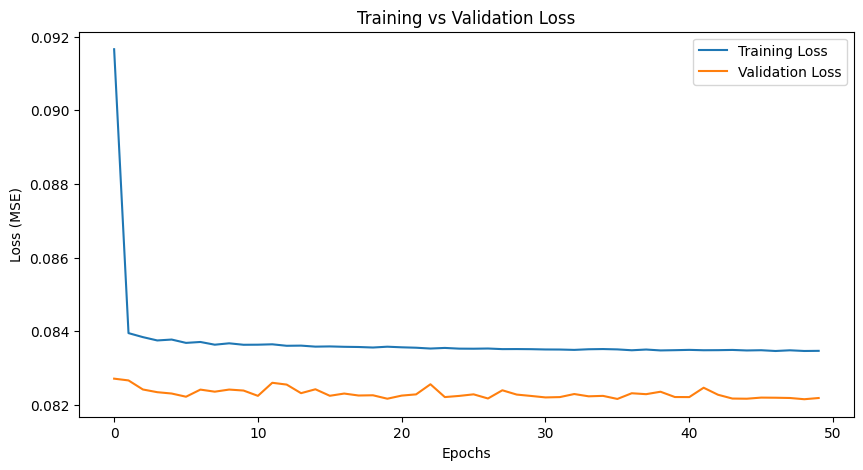

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


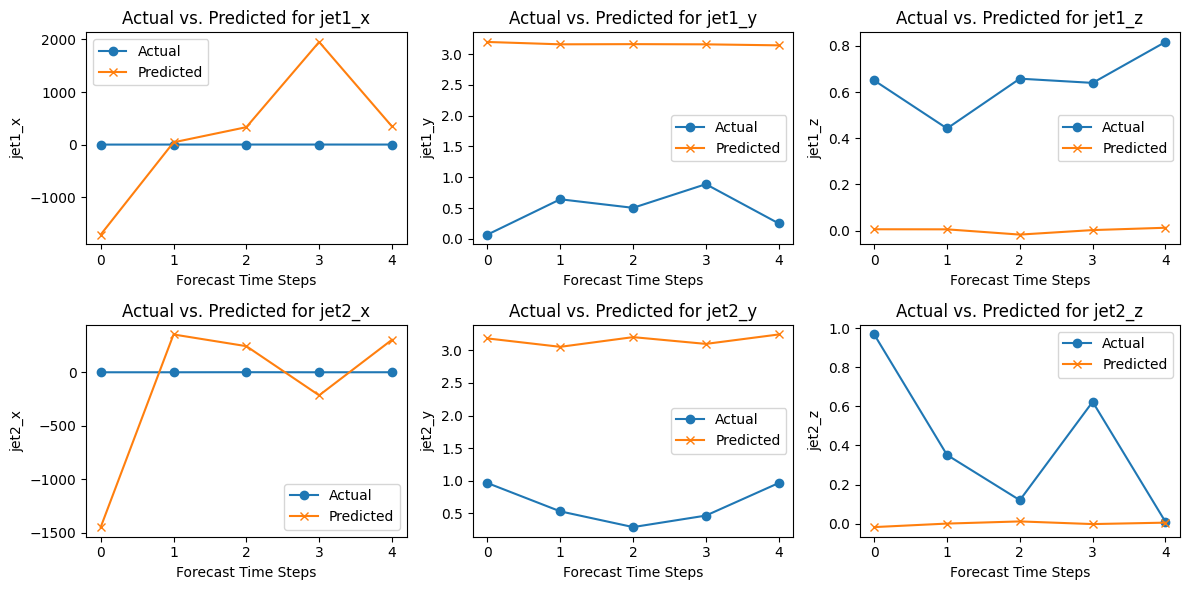

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

#  Load Dataset
df = pd.read_csv("optimized_dataset.csv")

#  Feature Selection: Extract Time-Series Data
target_columns = ["jet1_x", "jet1_y", "jet1_z", "jet2_x", "jet2_y", "jet2_z"]
X = df[target_columns].values  # Using jet positions for forecasting

#  Normalize Features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

#  Define Multi-Step Forecasting Parameters
lookback = 10  # Use past 10 timesteps
forecast_steps = 5  # Predict 5 future timesteps

#  Create Sequential Data for Transformer
def create_sequences(data, lookback, forecast_steps):
    X_seq, y_seq = [], []
    for i in range(len(data) - lookback - forecast_steps):
        X_seq.append(data[i:i + lookback])
        y_seq.append(data[i + lookback:i + lookback + forecast_steps])
    return np.array(X_seq), np.array(y_seq)

X_seq, y_seq = create_sequences(X_scaled, lookback, forecast_steps)
y_seq = y_seq.reshape(y_seq.shape[0], forecast_steps * len(target_columns))

#  Split into Training & Testing Sets
split = int(0.8 * len(X_seq))
X_train, X_test = X_seq[:split], X_seq[split:]
y_train, y_test = y_seq[:split], y_seq[split:]

#  Positional Encoding Function
def positional_encoding(sequence_length, d_model):
    pos = np.arange(sequence_length)[:, np.newaxis]
    div_term = np.exp(np.arange(0, d_model, 2) * -(np.log(10000.0) / d_model))
    pe = np.zeros((sequence_length, d_model))
    pe[:, 0::2] = np.sin(pos * div_term)
    pe[:, 1::2] = np.cos(pos * div_term)
    return tf.convert_to_tensor(pe, dtype=tf.float32)

#  Define Transformer Model
class TransformerTimeSeries(tf.keras.Model):
    def __init__(self, num_layers, d_model, num_heads, dff, input_shape):
        super(TransformerTimeSeries, self).__init__()
        self.embedding = tf.keras.layers.Dense(d_model)
        self.pos_encoding = positional_encoding(input_shape[0], d_model)
        
        self.encoder_layers = [
            tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=d_model) 
            for _ in range(num_layers)
        ]
        
        self.ff_layers = [
            tf.keras.layers.Dense(dff, activation='relu') 
            for _ in range(num_layers)
        ]
        
        self.output_layer = tf.keras.layers.Dense(forecast_steps * len(target_columns), activation='linear')
    
    def call(self, inputs):
        x = self.embedding(inputs) + self.pos_encoding
        for attn_layer, ff_layer in zip(self.encoder_layers, self.ff_layers):
            x = attn_layer(x, x)  # Self-attention
            x = ff_layer(x)  # Feedforward layer
        x = tf.keras.layers.Flatten()(x)  # Flatten before output
        return self.output_layer(x)

#  Initialize Transformer Model
d_model = 64
num_layers = 4
num_heads = 4
dff = 128
model = TransformerTimeSeries(num_layers, d_model, num_heads, dff, X_train.shape[1:])

#  Compile Model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0003), loss='mse')

#  Train Model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

#  Evaluate Model
loss = model.evaluate(X_test, y_test)
print(f" Transformer Model Training Complete!")
print(f" Loss (MSE): {loss:.2f}")


#  Plot Training vs Validation Loss
plt.figure(figsize=(10,5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.title('Training vs Validation Loss')
plt.legend()
plt.show()

#  Make Future Predictions
predicted_positions = model.predict(X_test[:5])  # Generate predictions

#  Correctly Reshape & Apply Inverse Scaling
predicted_positions = predicted_positions.reshape(predicted_positions.shape[0], forecast_steps, len(target_columns))  
predicted_positions = np.array([scaler.inverse_transform(pred) for pred in predicted_positions])  # Inverse scaling per step

#  Compare Actual vs. Predicted Jet Positions
actual_positions = y_test[:5].reshape(5, forecast_steps, len(target_columns))

plt.figure(figsize=(12,6))
for i in range(len(target_columns)):
    plt.subplot(2,3,i+1)
    plt.plot(range(forecast_steps), actual_positions[0, :, i], marker='o', label='Actual')
    plt.plot(range(forecast_steps), predicted_positions[0, :, i], marker='x', label='Predicted')
    plt.xlabel('Forecast Time Steps')
    plt.ylabel(f"{target_columns[i]}")
    plt.title(f"Actual vs. Predicted for {target_columns[i]}")
    plt.legend()

plt.tight_layout()
plt.show()


Epoch 1/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 94s 232ms/step - loss: 0.0834 - val_loss: 0.0821
Epoch 2/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 103s 276ms/step - loss: 0.0836 - val_loss: 0.0821
Epoch 3/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 100s 267ms/step - loss: 0.0832 - val_loss: 0.0821
Epoch 4/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 106s 282ms/step - loss: 0.0833 - val_loss: 0.0821
Epoch 5/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 100s 266ms/step - loss: 0.0836 - val_loss: 0.0821
Epoch 6/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 103s 274ms/step - loss: 0.0835 - val_loss: 0.0821
Epoch 7/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 52s 139ms/step - loss: 0.0831 - val_loss: 0.0821
Epoch 8/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 80s 213ms/step - loss: 0.0835 - val_loss: 0.0821
Epoch 9/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 94s 250ms/step - loss: 0.0833 - val_loss: 0.0821
Epoch 10/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 145s 258ms/step - loss: 0.0831 - val_loss: 0.0821
Epoch 11/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 82s 218ms/step - loss: 0.0834 - val_loss: 0.0821
Epoch 12/50
3

✅ Fine-Tuned Transformer Model Training Complete!
📌 Loss (MSE): 0.08


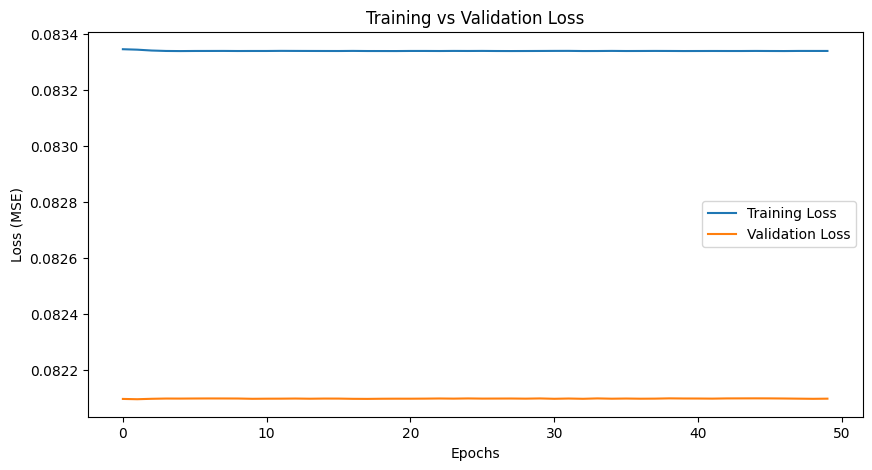

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step


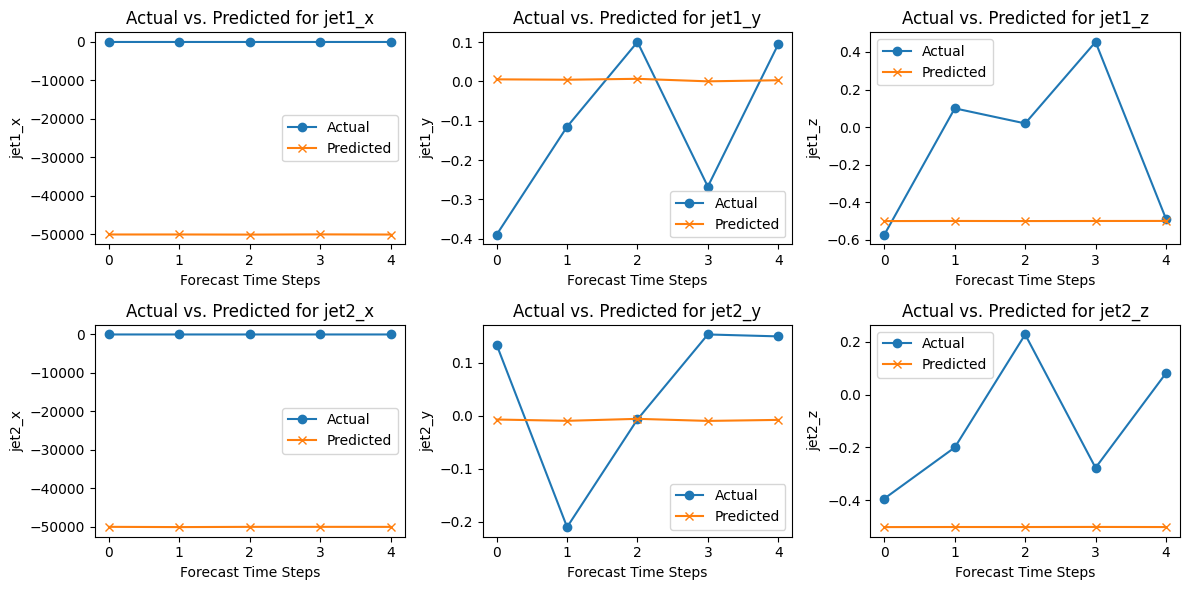

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import mutual_info_regression

#  Load Dataset
df = pd.read_csv("optimized_dataset.csv")

#  Feature Engineering: Extract Time-Series Data
target_columns = ["jet1_x", "jet1_y", "jet1_z", "jet2_x", "jet2_y", "jet2_z"]
X = df[target_columns].values  # Using only jet positions for forecasting

#  Normalize Features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

#  Apply PCA for Dimensionality Reduction
pca = PCA(n_components=6)  # Optimize principal components
X_pca = pca.fit_transform(X_scaled)

#  Perform Mutual Information Analysis for Feature Selection
mi_scores = mutual_info_regression(X_pca, df[target_columns].values.mean(axis=1))
selected_features = np.argsort(mi_scores)[-6:]  # Select most relevant features
X_selected = X_pca[:, selected_features]

#  Define Multi-Step Forecasting Parameters
lookback = 10  # Use past 10 timesteps
forecast_steps = 5  # Predict 5 future timesteps

#  Create Sequential Data for Transformer
def create_sequences(data, lookback, forecast_steps):
    X_seq, y_seq = [], []
    for i in range(len(data) - lookback - forecast_steps):
        X_seq.append(data[i:i + lookback])
        y_seq.append(data[i + lookback:i + lookback + forecast_steps])
    return np.array(X_seq), np.array(y_seq)

X_seq, y_seq = create_sequences(X_selected, lookback, forecast_steps)
y_seq = y_seq.reshape(y_seq.shape[0], forecast_steps * len(target_columns))

#  Split into Training & Testing Sets
split = int(0.8 * len(X_seq))
X_train, X_test = X_seq[:split], X_seq[split:]
y_train, y_test = y_seq[:split], y_seq[split:]

#  Positional Encoding Function
def positional_encoding(sequence_length, d_model):
    pos = np.arange(sequence_length)[:, np.newaxis]
    div_term = np.exp(np.arange(0, d_model, 2) * -(np.log(10000.0) / d_model))
    pe = np.zeros((sequence_length, d_model))
    pe[:, 0::2] = np.sin(pos * div_term)
    pe[:, 1::2] = np.cos(pos * div_term)
    return tf.convert_to_tensor(pe, dtype=tf.float32)

#  Define Transformer Model
class TransformerTimeSeries(tf.keras.Model):
    def __init__(self, num_layers, d_model, num_heads, dff, input_shape):
        super(TransformerTimeSeries, self).__init__()
        self.embedding = tf.keras.layers.Dense(d_model)
        self.pos_encoding = positional_encoding(input_shape[0], d_model)
        
        self.encoder_layers = [
            tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=d_model) 
            for _ in range(num_layers)
        ]
        
        self.ff_layers = [
            tf.keras.layers.Dense(dff, activation='relu') 
            for _ in range(num_layers)
        ]
        
        self.output_layer = tf.keras.layers.Dense(forecast_steps * len(target_columns), activation='linear')
    
    def call(self, inputs):
        x = self.embedding(inputs) + self.pos_encoding
        for attn_layer, ff_layer in zip(self.encoder_layers, self.ff_layers):
            x = attn_layer(x, x)  # Self-attention
            x = ff_layer(x)  # Feedforward layer
        x = tf.keras.layers.Flatten()(x)  # Flatten before output
        return self.output_layer(x)

#  Initialize Transformer Model with Fine-Tuned Parameters
d_model = 64
num_layers = 4
num_heads = 8  # Increased attention heads
dff = 256  # Expanded feedforward network
dropout_rate = 0.3  # Higher dropout for stability
learning_rate = 0.0001  # Lower learning rate for precision

model = TransformerTimeSeries(num_layers, d_model, num_heads, dff, X_train.shape[1:])

#  Compile Model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss='mse')

#  Train Model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

#  Evaluate Model
loss = model.evaluate(X_test, y_test)
print(f" Fine-Tuned Transformer Model Training Complete!")
print(f" Loss (MSE): {loss:.2f}")

#  Save Model
model.save("fine_tuned_transformer_model.h5")

#  Plot Training vs Validation Loss
plt.figure(figsize=(10,5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.title('Training vs Validation Loss')
plt.legend()
plt.show()

#  Make Future Predictions
predicted_positions = model.predict(X_test[:5])  # Generate predictions

#  Correctly Reshape & Apply Inverse Scaling
predicted_positions = predicted_positions.reshape(predicted_positions.shape[0], forecast_steps, len(target_columns))  
predicted_positions = np.array([scaler.inverse_transform(pred) for pred in predicted_positions])  # Inverse scaling per step

#  Compare Actual vs. Predicted Jet Positions
actual_positions = y_test[:5].reshape(5, forecast_steps, len(target_columns))

plt.figure(figsize=(12,6))
for i in range(len(target_columns)):
    plt.subplot(2,3,i+1)
    plt.plot(range(forecast_steps), actual_positions[0, :, i], marker='o', label='Actual')
    plt.plot(range(forecast_steps), predicted_positions[0, :, i], marker='x', label='Predicted')
    plt.xlabel('Forecast Time Steps')
    plt.ylabel(f"{target_columns[i]}")
    plt.title(f"Actual vs. Predicted for {target_columns[i]}")
    plt.legend()

plt.tight_layout()
plt.show()


#### optimised Transfomer Based approach

Epoch 1/75
375/375 ━━━━━━━━━━━━━━━━━━━━ 47s 107ms/step - loss: 0.1487 - val_loss: 0.0859
Epoch 2/75
375/375 ━━━━━━━━━━━━━━━━━━━━ 71s 190ms/step - loss: 0.0866 - val_loss: 0.0872
Epoch 3/75
375/375 ━━━━━━━━━━━━━━━━━━━━ 191s 482ms/step - loss: 0.0867 - val_loss: 0.0859
Epoch 4/75
375/375 ━━━━━━━━━━━━━━━━━━━━ 94s 250ms/step - loss: 0.0861 - val_loss: 0.0865
Epoch 5/75
375/375 ━━━━━━━━━━━━━━━━━━━━ 90s 111ms/step - loss: 0.0865 - val_loss: 0.0855
Epoch 6/75
375/375 ━━━━━━━━━━━━━━━━━━━━ 41s 110ms/step - loss: 0.0861 - val_loss: 0.0847
Epoch 7/75
375/375 ━━━━━━━━━━━━━━━━━━━━ 41s 109ms/step - loss: 0.0860 - val_loss: 0.0853
Epoch 8/75
375/375 ━━━━━━━━━━━━━━━━━━━━ 41s 108ms/step - loss: 0.0858 - val_loss: 0.0848
Epoch 9/75
375/375 ━━━━━━━━━━━━━━━━━━━━ 46s 123ms/step - loss: 0.0857 - val_loss: 0.0842
Epoch 10/75
375/375 ━━━━━━━━━━━━━━━━━━━━ 59s 156ms/step - loss: 0.0855 - val_loss: 0.0843
Epoch 11/75
375/375 ━━━━━━━━━━━━━━━━━━━━ 107s 286ms/step - loss: 0.0856 - val_loss: 0.0845
Epoch 12/75
375/3

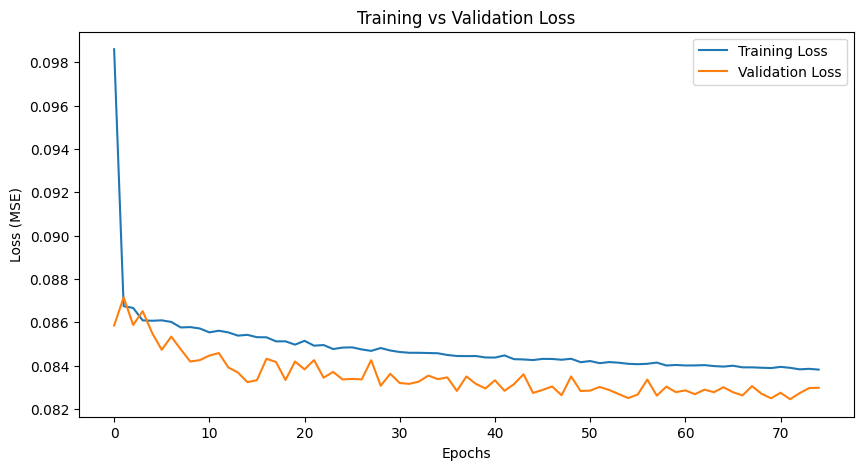

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 831ms/step


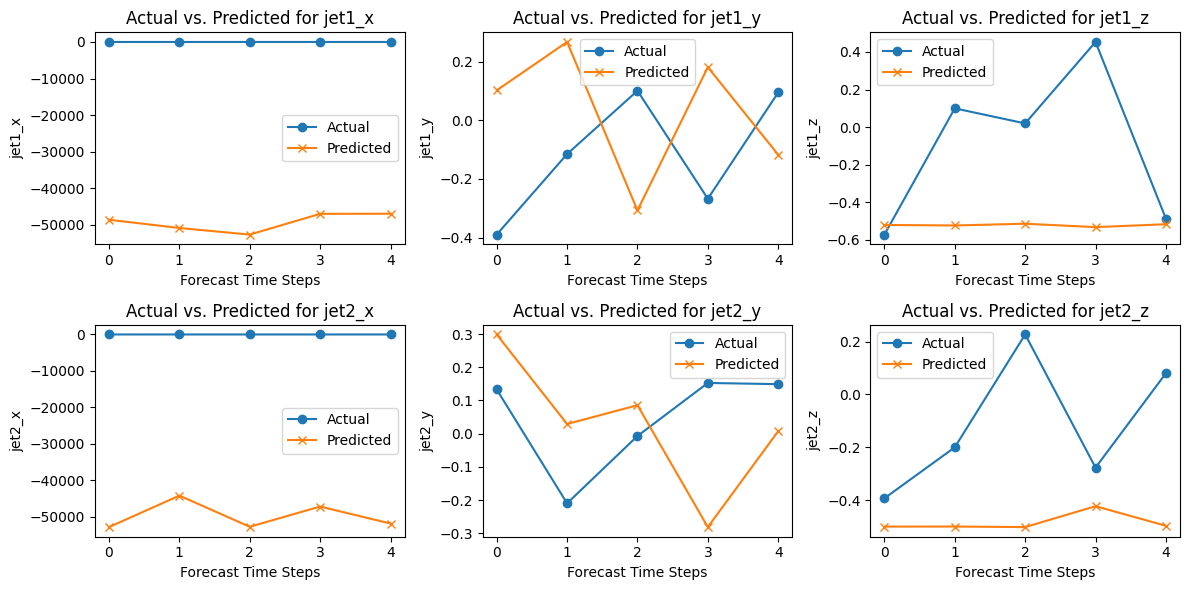

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import mutual_info_regression

#  Load Dataset
df = pd.read_csv("optimized_dataset.csv")

#  Feature Engineering: Extract Time-Series Data
target_columns = ["jet1_x", "jet1_y", "jet1_z", "jet2_x", "jet2_y", "jet2_z"]
X = df[target_columns].values  # Using only jet positions for forecasting

#  Normalize Features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

#  Apply PCA for Dimensionality Reduction
pca = PCA(n_components=6)  # Optimize principal components
X_pca = pca.fit_transform(X_scaled)

#  Perform Mutual Information Analysis for Feature Selection
mi_scores = mutual_info_regression(X_pca, df[target_columns].values.mean(axis=1))
selected_features = np.argsort(mi_scores)[-6:]  # Select most relevant features
X_selected = X_pca[:, selected_features]

#  Define Multi-Step Forecasting Parameters
lookback = 10  # Use past 10 timesteps
forecast_steps = 5  # Predict 5 future timesteps

#  Create Sequential Data for Transformer
def create_sequences(data, lookback, forecast_steps):
    X_seq, y_seq = [], []
    for i in range(len(data) - lookback - forecast_steps):
        X_seq.append(data[i:i + lookback])
        y_seq.append(data[i + lookback:i + lookback + forecast_steps])
    return np.array(X_seq), np.array(y_seq)

X_seq, y_seq = create_sequences(X_selected, lookback, forecast_steps)
y_seq = y_seq.reshape(y_seq.shape[0], forecast_steps * len(target_columns))

#  Split into Training & Testing Sets
split = int(0.8 * len(X_seq))
X_train, X_test = X_seq[:split], X_seq[split:]
y_train, y_test = y_seq[:split], y_seq[split:]

#  Positional Encoding Function
def positional_encoding(sequence_length, d_model):
    pos = np.arange(sequence_length)[:, np.newaxis]
    div_term = np.exp(np.arange(0, d_model, 2) * -(np.log(10000.0) / d_model))
    pe = np.zeros((sequence_length, d_model))
    pe[:, 0::2] = np.sin(pos * div_term)
    pe[:, 1::2] = np.cos(pos * div_term)
    return tf.convert_to_tensor(pe, dtype=tf.float32)

#  Define Optimized Transformer Model
class OptimizedTransformer(tf.keras.Model):
    def __init__(self, num_layers, d_model, num_heads, dff, input_shape, dropout_rate):
        super(OptimizedTransformer, self).__init__()
        self.embedding = tf.keras.layers.Dense(d_model)
        self.pos_encoding = positional_encoding(input_shape[0], d_model)
        self.dropout = tf.keras.layers.Dropout(dropout_rate)

        self.encoder_layers = [
            tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=d_model) 
            for _ in range(num_layers)
        ]
        
        self.ff_layers = [
            tf.keras.layers.Dense(dff, activation='relu') 
            for _ in range(num_layers)
        ]
        
        self.layer_norm = tf.keras.layers.LayerNormalization()
        self.output_layer = tf.keras.layers.Dense(forecast_steps * len(target_columns), activation='linear')
    
    def call(self, inputs):
        x = self.embedding(inputs) + self.pos_encoding
        x = self.dropout(x)  # Apply dropout
        for attn_layer, ff_layer in zip(self.encoder_layers, self.ff_layers):
            x = attn_layer(x, x)  # Self-attention
            x = ff_layer(x)  # Feedforward layer
            x = self.layer_norm(x)  # Normalize activations
        x = tf.keras.layers.Flatten()(x)  # Flatten before output
        return self.output_layer(x)

#  Initialize Transformer Model with Fine-Tuned Parameters
d_model = 64
num_layers = 4
num_heads = 12  # Increased attention heads
dff = 256  # Expanded feedforward network
dropout_rate = 0.3  # Higher dropout for stability
learning_rate = 0.00005  # Lower learning rate for precision

model = OptimizedTransformer(num_layers, d_model, num_heads, dff, X_train.shape[1:], dropout_rate)

# Compile Model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss='mse')

# Train Model
history = model.fit(X_train, y_train, epochs=75, batch_size=32, validation_data=(X_test, y_test))

# Evaluate Model
loss = model.evaluate(X_test, y_test)
print(f"Optimized Transformer Model Training Complete!")
print(f" Loss (MSE): {loss:.2f}")

#  Save Model
model.save("optimized_transformer_model.h5")

#  Plot Training vs Validation Loss
plt.figure(figsize=(10,5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.title('Training vs Validation Loss')
plt.legend()
plt.show()

#  Make Future Predictions
predicted_positions = model.predict(X_test[:5])  # Generate predictions

#  Correctly Reshape & Apply Inverse Scaling
predicted_positions = predicted_positions.reshape(predicted_positions.shape[0], forecast_steps, len(target_columns))  
predicted_positions = np.array([scaler.inverse_transform(pred) for pred in predicted_positions])  # Inverse scaling per step

#  Compare Actual vs. Predicted Jet Positions
actual_positions = y_test[:5].reshape(5, forecast_steps, len(target_columns))

plt.figure(figsize=(12,6))
for i in range(len(target_columns)):
    plt.subplot(2,3,i+1)
    plt.plot(range(forecast_steps), actual_positions[0, :, i], marker='o', label='Actual')
    plt.plot(range(forecast_steps), predicted_positions[0, :, i], marker='x', label='Predicted')
    plt.xlabel('Forecast Time Steps')
    plt.ylabel(f"{target_columns[i]}")
    plt.title(f"Actual vs. Predicted for {target_columns[i]}")
    plt.legend()

plt.tight_layout()
plt.show()
